In [1]:
import os
from pathlib import Path

module_path = str(Path().resolve())
os.environ['PYTHONPATH'] = module_path

module_path

'/app/app/src'

In [2]:
!pip install "ray[tune]==2.10.0"

In [3]:
!pip install bayesian-optimization==1.4.3

In [4]:
!pip install seaborn

In [5]:
!pip install xgboost

In [6]:
import os
import shutil
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam

import ray
from ray import tune
from ray import train
from ray.train import Checkpoint, CheckpointConfig

from ray.tune import ExperimentAnalysis
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.schedulers.async_hyperband import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
xgb.set_config(verbosity=2)

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

# Recog

In [7]:
df_train = pd.read_csv("data/train_reviews_merged_final.csv")
df_train['text'] = df_train['text'].fillna("")

df_train.sample(5)

,stars,useful,funny,cool,text,date,stars_neg,review_count_neg,is_open_neg,categories_neg,review_count_user,average_stars_user,compliment_user
775921,5.0,0.266410,0.300774,0.255613,Great breakfast!! I got the Mama Mumbo and it ...,2018,4.0,9.692302,True,Restaurante,-0.288352,4.50,-0.035085
736283,4.0,-0.391093,-0.150312,-0.251644,PB's is a great place to stop in for any meal ...,2012,2.5,0.591121,False,Restaurante,-0.263747,4.20,-0.030243
114886,2.0,-0.391093,-0.150312,-0.251644,Snappers gets two stars because the hospitalit...,2020,4.5,10.642817,True,Restaurante,-0.165329,4.15,-0.035085
37875,5.0,-0.062341,-0.150312,-0.251644,Good food. Can't complain. It was in a hole in...,2021,3.5,0.385176,True,Restaurante,-0.050509,3.50,-0.035085
415452,5.0,-0.391093,-0.150312,-0.251644,"everyone at Lasik Plus was very happy, helpful...",2016,4.5,0.060417,True,Otros,-0.296553,5.00,-0.035085


In [8]:
X_numeric = df_train[["useful", "funny", "cool", "stars_neg", "review_count_neg", "categories_neg", "review_count_user", "average_stars_user", 
                     "compliment_user"]].copy()
X_numeric["is_open_neg"] = df_train["is_open_neg"].astype(int)

X_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,review_count_user,average_stars_user,compliment_user,is_open_neg
759793,-0.062341,0.300774,0.255613,4.5,0.702014,Restaurante,-0.214538,3.85,-0.030243,1
422026,-0.391093,-0.150312,0.255613,4.0,0.179231,Restaurante,0.064312,3.83,-0.035085,1
656835,-0.391093,-0.150312,0.255613,4.5,0.963406,Restaurante,-0.148926,3.95,-0.031454,1
401231,-0.062341,-0.150312,-0.251644,2.0,-0.240580,Restaurante,-0.271949,2.71,-0.035085,1
74469,-0.062341,-0.150312,-0.251644,4.0,-0.296027,Otros,-0.173531,1.00,-0.033875,1


In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X_numeric['categories_neg'] = label_encoder.fit_transform(X_numeric['categories_neg'])

X_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,review_count_user,average_stars_user,compliment_user,is_open_neg
692559,0.266410,-0.150312,-0.251644,4.0,2.317890,4,-0.271949,3.75,-0.035085,1
87692,-0.391093,-0.150312,-0.251644,4.5,-0.224738,5,-0.263747,4.33,-0.035085,1
149225,-0.391093,1.202944,-0.251644,4.0,2.072340,4,-0.124322,4.41,-0.031454,1
529243,-0.391093,-0.150312,-0.251644,4.5,16.488485,4,-0.247344,4.43,-0.035085,1
723172,0.266410,-0.150312,-0.251644,4.5,11.110154,4,2.647781,3.50,0.079913,1


In [10]:
text = df_train["text"]
text

0         Fantastic fresh food. The greek salad is amazi...
1         Been a patient at Largo Med/Diagnostic Clinic ...
2         The location is convenient to my campus so I d...
3         I agree with all the other compliments posted ...
4         Wanting to help out the local economy, I thoug...
                                ...                        
967779    Ordered takeout and this place didn't disappoi...
967780    I took our annual managers meeting there for d...
967781    My favorite local coffee shop! Great drinks (i...
967782    We hit a quiet time here on a very busy weeken...
967783    On-line buyer beware, I had to return a top th...
Name: text, Length: 967784, dtype: object

# Search Space

In [11]:
booster_dict = {
    1: "gbtree",
    2: "gblinear",
    3: "dart"
}

tree_method_dict = {
    1: "auto",
    2: "approx",
    3: "hist"
}


grow_policy_dict = {
    1: "depthwise",
    2: "lossguide"
}

space = {
    # Categóricos indexados
    "booster_idx": tune.randint(1, 4),
    "tree_method_idx": tune.randint(1, 4),
    "grow_policy_idx": tune.randint(1, 3),

    # Numéricos continuos o log-uniformes
    "eta": tune.loguniform(1e-3, 0.7),
    "gamma": tune.uniform(0.0, 10.0),
    "max_depth": tune.qloguniform(3, 12, 1),
    "min_child_weight": tune.uniform(1, 5),
    "max_delta_step": tune.uniform(0, 5),
    "subsample": tune.uniform(0.2, 1.0),
    "lambda": tune.loguniform(1e-3, 10.0),
    "alpha": tune.loguniform(1e-3, 10.0),
    "scale_pos_weight": tune.uniform(0.5, 5),
    "max_leaves": tune.qloguniform(1, 10, 1),
    "max_bin": tune.qloguniform(125, 525, 25),


    # # Embedding
    # "ngram_range_x": tune.randint(1,3),
    # "max_features": tune.qloguniform(5_000, 20_000, 1_000),
    # "n_components": tune.qloguniform(50, 150, 25),
}


#  Objective Function

In [12]:
from functools import lru_cache

def get_data():
    X_text_reduced = np.load("/app/app/src/data/embeddings_text_train_DL.npy", mmap_mode='r')
    X_final = np.hstack([X_numeric.values, X_text_reduced])
    y = df_train["stars"]
    return train_test_split(X_final, y, test_size=0.2, random_state=42)

In [13]:
def objective(config, get_data):
    X_train, X_test, y_train, y_test = get_data()

    # Estos sí los acepta XGBRegressor directamente
    regressor_params = {
        "booster": booster_dict[int(config["booster_idx"])],
        "eta": float(config["eta"]),
        "max_depth": int(config["max_depth"]),
        "min_child_weight": int(config["min_child_weight"]),
        "subsample": float(config["subsample"]),
        "reg_lambda": float(config["lambda"]),
        "reg_alpha": float(config["alpha"]),
        "scale_pos_weight": float(config["scale_pos_weight"]),
        "verbosity": 0,
        "eval_metric":"mae",
        "random_state": 42,
        "n_jobs": 16
    }
    
    # Estos deben ir en fit() o no se usan
    unused_params = {
        "gamma": float(config["gamma"]),
        "grow_policy": grow_policy_dict[int(config["grow_policy_idx"])],
        "max_bin": int(config["max_bin"]),
        "max_delta_step": float(config["max_delta_step"]),
        "max_leaves": int(config["max_leaves"]),
        "tree_method": tree_method_dict[int(config["tree_method_idx"])],
        "sampling_method": "uniform"
    }

    model = XGBRegressor(**regressor_params)
    model.set_params(**unused_params)  

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)

    print(f"MAE: {mae}")
        
    train.report({
        "mae": mae
    })

#  Test the Objective Function

In [14]:
def sample(space):
    config = {}
    for key in space:
        config[key] = space[key].sample()
    return config

In [15]:
config = sample(space)

print(f"""Testing config:
  booster: {booster_dict[int(config["booster_idx"])]}
  tree_method: {tree_method_dict[int(config["tree_method_idx"])]}
  grow_policy: {grow_policy_dict[int(config["grow_policy_idx"])]}
  eta: {float(config['eta']):.5f}
  gamma: {float(config['gamma']):.5f}
  max_depth: {int(config['max_depth'])}
  min_child_weight: {int(config['min_child_weight'])}
  max_delta_step: {float(config['max_delta_step']):.3f}
  subsample: {float(config['subsample']):.3f}
  lambda: {float(config['lambda']):.5f}
  alpha: {float(config['alpha']):.5f}
  scale_pos_weight: {int(config['scale_pos_weight'])}
  max_leaves: {int(config['max_leaves'])}
  max_bin: {int(config['max_bin'])}
""")


Testing config:
  booster: gblinear
  tree_method: auto
  grow_policy: lossguide
  eta: 0.00161
  gamma: 4.71271
  max_depth: 6
  min_child_weight: 4
  max_delta_step: 0.043
  subsample: 0.704
  lambda: 0.26362
  alpha: 0.76499
  scale_pos_weight: 4
  max_leaves: 2
  max_bin: 175



In [16]:
objective(config, get_data)

MAE: 1.6082945610180739


# Setting up Training

# Search Algorithm

In [17]:
!pip install optuna

In [18]:
from optuna.samplers import TPESampler

search_alg = OptunaSearch(
    sampler=TPESampler(
        n_startup_trials=5,         # Número de pruebas aleatorias antes de empezar la exploración bayesiana
        multivariate=True,          # Considera dependencias entre parámetros
        group=True                  # Agrupa parámetros relacionados (mejor para modelos grandes)
    ),
    metric="mae",
    mode="min"
)

# Scheduler

In [19]:
scheduler = ASHAScheduler(
    metric='mae', 
    mode='min',
    max_t=100,             # número máximo de iteraciones (puede ser num_boost_round)
    grace_period=5,       # deja correr las pruebas al menos 10 iteraciones antes de descartar
    reduction_factor=3     # controla cuántos se promueven vs descartan
)

# Tune Config

In [20]:
 tune_config = tune.TuneConfig( 
    search_alg=search_alg,
    num_samples=1_000,
    scheduler=scheduler,
    max_concurrent_trials=5,    
)

In [21]:
run_config = train.RunConfig(
        name='temaleos_Y',
        storage_path='/app/app/src/tune_Y',
        verbose = 1,
    )

In [22]:
objective = tune.with_resources(
         objective,
         {
             'cpu': 30, 
             'gpu': .5, 
             'memory': 20 * 1024**3
         }
     )

In [23]:
tuner = tune.Tuner(
         tune.with_parameters(objective, get_data=get_data),
         tune_config=tune_config,
         param_space=space,
         run_config=run_config,
     )

In [24]:
!pip install grpcio

In [25]:
while ray.is_initialized():
          ray.shutdown()
ray.init()

2025-04-12 14:46:50,527	INFO worker.py:1752 -- Started a local Ray instance.


Python version:,3.11.11
Ray version:,2.10.0


(objective pid=131615) MAE: 1.4670700406841215
(objective pid=131467) MAE: 0.7917167087983235
(objective pid=132461) MAE: 0.7787741592946025
(objective pid=132288) MAE: 0.6852039563617484
(objective pid=132615) MAE: 1.3823672335829333
(objective pid=132769) MAE: 0.7602328488395284
(objective pid=132900) MAE: 0.7195847578960268
(objective pid=133073) MAE: 1.376411678696729
(objective pid=133246) MAE: 0.8909700487434506
(objective pid=133403) MAE: 0.6640890859558957
(objective pid=133574) MAE: 0.6741227209665026
(objective pid=134012) MAE: 1.5396166837459868 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(objective pid=133882) MAE: 0.9947370464270142
(objective pid=134335) MAE: 1.1208856362235262
(objective pid=134484) MAE: 0.6539621717791623 [repeated 2x across cluster]
(objective pid=134631) MAE: 0.6735722193566

In [ ]:
results = tuner.fit()

# Analyzing the Results

In [ ]:
best = results.get_best_result(metric='mae', mode='min')
print(f"MAE : {best.metrics['mae']}")

In [ ]:
best

In [ ]:
analysis = ExperimentAnalysis("/app/app/src/tune_Y/temaleos_Y")
best_config = analysis.get_best_config(metric="mae", mode="min")
best_config

In [ ]:
df.columns

In [24]:
df_copy = df.copy()

In [26]:
df_final = df_copy.drop(columns=['checkpoint_dir_name', 'done', 'trial_id', 'node_ip', 'time_since_restore', 
                                 'iterations_since_restore', 'hostname', 'pid', 'time_this_iter_s', 'time_total_s',
                                 'logdir', 'date'])
df_final.sample(5)

,val_loss,train_loss,savepath,timestamp,training_iteration,config/recogniser__training_batch_size,config/recogniser__learning_rate,config/model__image_output_dim,config/model__physical_output_dim,config/model__final_embedding_dim,config/epoch
426,1.051511,0.980489,/resources/models/2025-04-11_08-43-41_894_mjj/...,1744361031,1,32,0.002283,256,16,256,43
559,1.007510,1.001487,/resources/models/2025-04-11_08-55-49_332_zqi/...,1744361752,1,64,0.000013,128,32,64,14
745,1.056867,1.016360,/resources/models/2025-04-11_09-13-31_454_mdi/...,1744362818,1,8,0.001270,64,16,256,35
717,1.001611,1.000858,/resources/models/2025-04-11_09-10-44_629_zan/...,1744362653,1,32,0.000255,64,16,128,46
437,1.064334,0.923739,/resources/models/2025-04-11_08-44-39_249_uic/...,1744361085,1,2,0.000024,128,16,256,23


## Export CSV

In [55]:
df_final.to_csv('ray_recog_1.csv', index=False)

## Val Loss vs Learning Rate

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

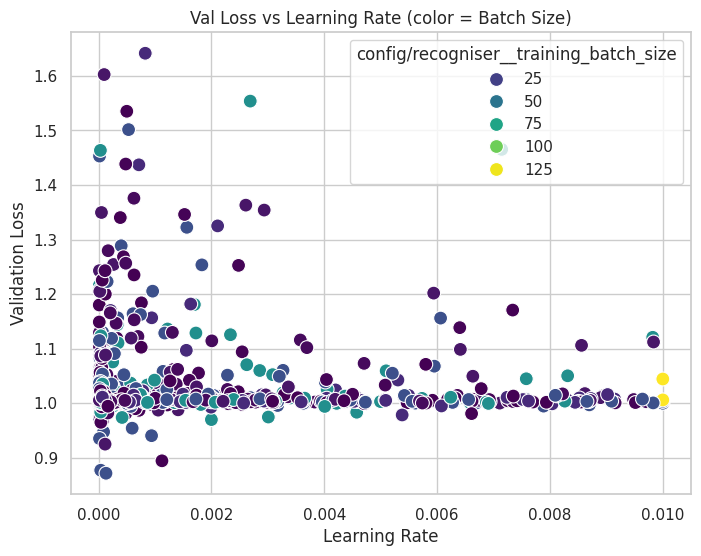

In [63]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_final, 
                x="config/recogniser__learning_rate", 
                y="val_loss", 
                hue="config/recogniser__training_batch_size", 
                palette="viridis", s=100)
plt.title("Val Loss vs Learning Rate (color = Batch Size)")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Loss")
plt.show()

## Val Loss vs Tamaño de Batch

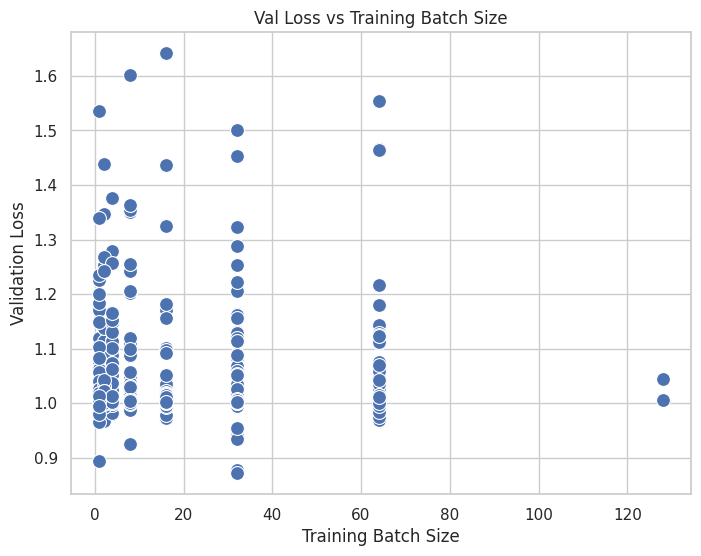

In [65]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_final, 
                x="config/recogniser__training_batch_size", 
                y="val_loss", 
                palette="viridis", s=100)
plt.title("Val Loss vs Training Batch Size")
plt.xlabel("Training Batch Size")
plt.ylabel("Validation Loss")
plt.show()

## Val Loss vs Final Embedding Dim

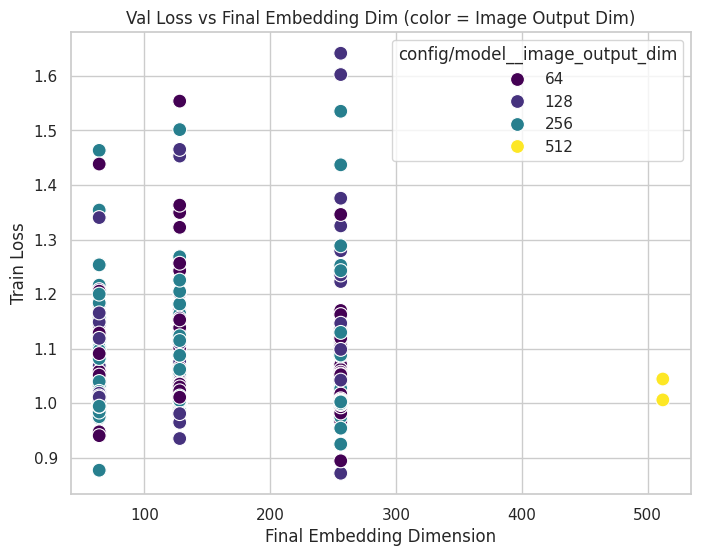

In [71]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_final, 
                x="config/model__final_embedding_dim", 
                y="val_loss", 
                hue="config/model__image_output_dim", 
                palette="viridis", s=100)
plt.title("Val Loss vs Final Embedding Dim (color = Image Output Dim)")
plt.xlabel("Final Embedding Dimension")
plt.ylabel("Train Loss")
plt.show()

## Heatmap

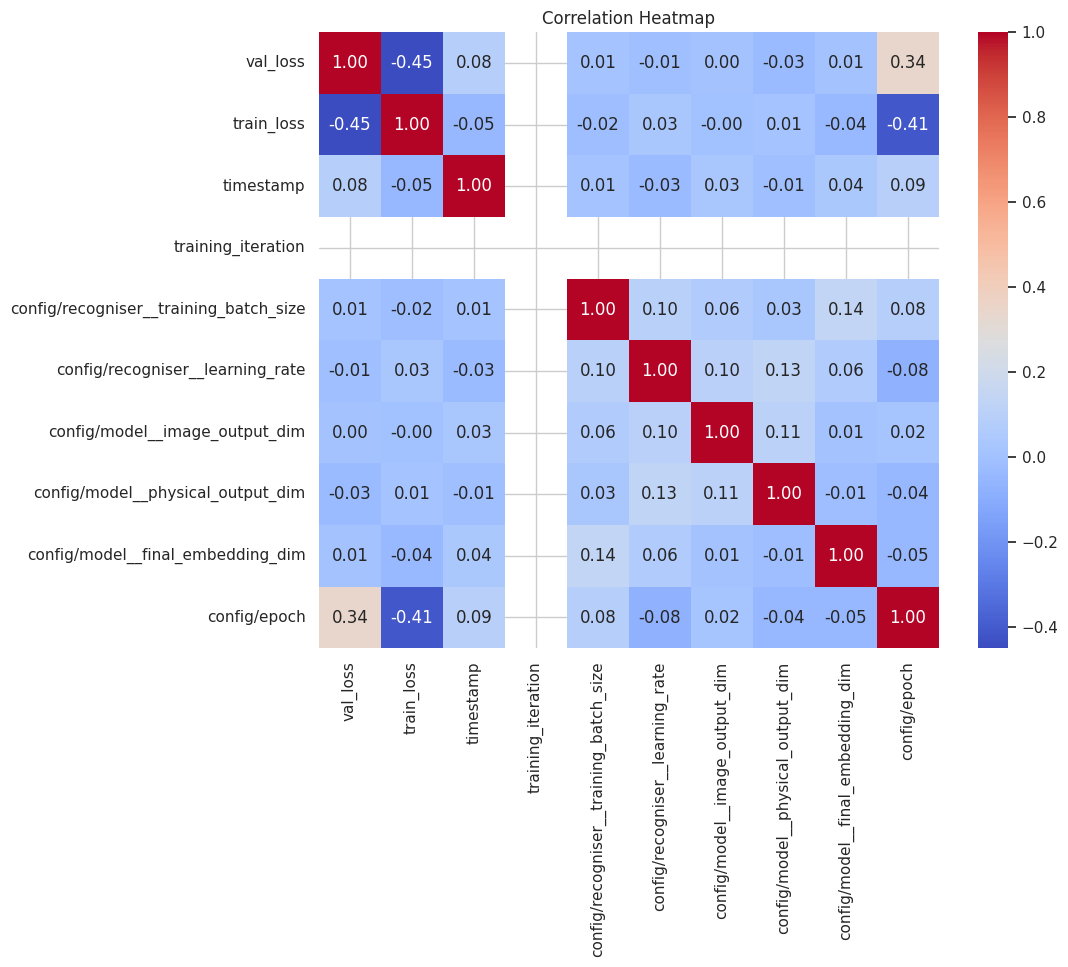

In [68]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_final.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()